In [1]:
library(tidyverse)
library(data.table)
library(showtext)
library(rgdal)
library(factoextra)
library(cluster)
library(leaflet)
font_add_google('Nanum Pen Script', 'nanumpen')
showtext_auto()

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: sysfonts

Loading required package: showtextdb

Loading required package: sp

rgdal: version: 1.5-16, (SVN revision 1050)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.1.2, released 2020/07/07
Path to GDAL shared files: /usr/local/gdal-3.1.2/share/gdal
GDAL binary built with GEOS: FALSE 
Loaded PROJ runtime: Rel. 6.1.0, May 15th, 2019, [PJ_VERS

## 1. '9.용인시_도로명주소_도로.geojson' 전처리 및 csv 저장

In [2]:
road <- readOGR(dsn = "9.용인시_도로명주소_도로.geojson")

OGR data source with driver: GeoJSON 
Source: "/opt/app-root/src/코드/9.용인시_도로명주소_도로.geojson", layer: "용인시_도로명주소_도로"
with 5891 features
It has 11 fields


In [3]:
road@data$id <- rownames(road@data)
road_df <- fortify(road, region = "id")
road_df <- merge(road_df, road@data, by = "id")

#### 16번 데이터 좌표와 9번 데이터 좌표를 비교하여, 9번 데이터에 16번 gid값 넣기 

In [4]:
#16. 매출
data_16 <- readOGR(dsn = "16.용인시_소상공인_매출정보.geojson")
df <- data_16@data
poly_data <- data_16@polygons
road_df$gid <- rep(NA, nrow(road_df))

for(i in 1 : length(poly_data)){
    #if(i%%100 == 0) print(i)
    temp_coord = poly_data[[i]]@Polygons[[1]]@coords
    temp_coord = apply(temp_coord,2, round, digit = 6)
    temp_lon = temp_coord[,1]
    temp_lat = temp_coord[,2]
  
    temp_gid_index1 = which(min(temp_lon) <= road_df$long & 
                              road_df$long <= max(temp_lon) &
                              min(temp_lat) <= road_df$lat &
                              road_df$lat <= max(temp_lat))
    if(length(temp_gid_index1) != 0)
    {road_df$gid[temp_gid_index1] = levels(df$gid)[i]}   
}

OGR data source with driver: GeoJSON 
Source: "/opt/app-root/src/코드/16.용인시_소상공인_매출정보.geojson", layer: "용인시_사업장정보"
with 9915 features
It has 66 fields


In [5]:
## 격자별로 도로 위계별 개수 세기(고속도로, 대로, 로, 길)

road_df_dt <- road_df %>% na.omit() %>% distinct()  %>% select(id, gid, ROA_CLS_SE) %>% distinct() %>% group_by(gid, ROA_CLS_SE) %>%
summarize(N=n(), .groups="drop") %>% ungroup() %>% spread(key = ROA_CLS_SE, value = N, fill = 0)
colnames(road_df_dt) = c("gid", "ROA_CLS_SE_1", "ROA_CLS_SE_2", "ROA_CLS_SE_3", "ROA_CLS_SE_4")

In [6]:
write.csv(road_df_dt,'road.csv',row.names = FALSE, fileEncoding = "UTF-8")

## 2. '7.용인시_유동인구.csv' 전처리 및 csv 저장

In [7]:
data_17 <- fread("17.용인시_소상공인_매출정보.csv",
              header = T,
              stringsAsFactors = F,
              data.table = F,
              encoding = "UTF-8")

data_7 <- fread("7.용인시_유동인구.csv",
              header = T,
              stringsAsFactors = F,
              data.table = F,
              encoding = "UTF-8")

In [8]:
data_7 <- cbind(select(data_7, -c(lon, lat)), apply(select(data_7, c(lon, lat)), 2, round, digit = 6))

#### 16번 데이터 좌표와 7번 데이터 좌표를 비교하여, 7번 데이터에 16번 gid값 넣기 

In [9]:
data_7 <- cbind(select(data_7, -c(lon, lat)), apply(select(data_7, c(lon, lat)), 2, round, digit = 6))
df <- data_16@data
poly_data <- data_16@polygons

data_7$gid <- rep(NA, nrow(data_7))

for(i in 1 : length(poly_data)){
#    if(i%%100 == 0) print(i)
    temp_coord = poly_data[[i]]@Polygons[[1]]@coords
    temp_coord = apply(temp_coord,2, round, digit = 6)
    temp_lon = temp_coord[,1]
    temp_lat = temp_coord[,2]
  
    temp_gid_index1 = which(min(temp_lon) <= data_7$lon & 
                              data_7$lon <= max(temp_lon) &
                              min(temp_lat) <= data_7$lat &
                              data_7$lat <= max(temp_lat))
    if(length(temp_gid_index1) != 0)
    {data_7$gid[temp_gid_index1] = levels(df$gid)[i]}
}

In [10]:
## 시간대별 유동인구를 모두 더해서 월별 유동인구(TMST_total) 만들기

data_7_filter <- data_7 %>% filter(!is.na(gid)) %>% select(-c(lon, lat)) %>% 
    mutate(STD_YM = as.character(STD_YM)) %>% group_by(gid, STD_YM) %>% summarize_if(is.numeric, sum) %>% ungroup()
data_7_filter$TMST_total <- rowSums(select_if(data_7_filter, is.numeric))

#### 1. 월별 평균 유동인구(TMST_mean) = 월별 평균 유동인구
#### 2. 유동인구 증가율(flpop_rate) = (2분기 평균 유동인구 -  1분기 평균 유동인구)/1분기 평균 유동인구

In [11]:
data_7_filter2 <- data_7_filter %>% select(gid, STD_YM, TMST_total) %>%  spread(key = STD_YM, value = TMST_total)
data_7_filter2 <- replace(data_7_filter2, is.na(data_7_filter2), 0)
data_7_filter2 <- data_7_filter2 %>% mutate(TMST_quarter_1 = `201901`+`201902`+`201903`,
                                            TMST_quarter_2 = `201904`+`201905`+`201906`) %>% 
    mutate(flpop_rate = (TMST_quarter_2 - TMST_quarter_1)/TMST_quarter_1) %>%  
    mutate(flpop_rate = ifelse(flpop_rate == Inf, 1, 
                           ifelse(is.na(flpop_rate), 0, flpop_rate)),
           TMST_mean = (`201901`+`201902`+`201903`+`201904`+`201905`+`201906`)/6) %>% 
    select(gid, flpop_rate, TMST_mean)

In [12]:
write.csv(data_7_filter2, file = "pop_flow.csv", row.names = F, fileEncoding = "UTF-8")

## 3. '17.용인시_소상공인_매출정보.csv' 결합

In [13]:
road <- fread("road.csv",
             header = T,
             stringsAsFactors = F,
             data.table = F,
             encoding = "UTF-8")

pop_flow <- fread("pop_flow.csv",
                  header = T,
                  stringsAsFactors = F,
                  data.table = F,
                  encoding = "UTF-8",
                  drop = c("TMST_mean"))

data <- fread("17.용인시_소상공인_매출정보.csv",
             header = T,
             stringsAsFactors = F,
             data.table = F,
             encoding = "UTF-8")

### 용인시 청년 창업현황

#### 1. 연령대별 사업체 수에 대한 일원분산분석(ANOVA)

- 귀무가설(H0) : 연령대별 사업체 수 평균 차이가 없다

In [14]:
df_anova <- data %>% select(starts_with("rpr_per_age_bin")) %>%
    mutate(youth = rpr_per_age_bin_10+rpr_per_age_bin_20) %>% 
    gather(key = 'age',
           value = 'value',
           youth,
           rpr_per_age_bin_30to50,
           rpr_per_age_bin_50over) %>% 
    select(c(age,value)) %>% 
    mutate_at(vars(age), as.factor) %>% 
    filter(value != 0)

summary(aov(value~age, data = df_anova))

              Df Sum Sq Mean Sq F value Pr(>F)    
age            2 134868   67434   143.8 <2e-16 ***
Residuals   1820 853507     469                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

- P-value가 0.05보다 작으므로 연렵대별로 사업체 수 간의 차이가 있다고 볼 수 있음.

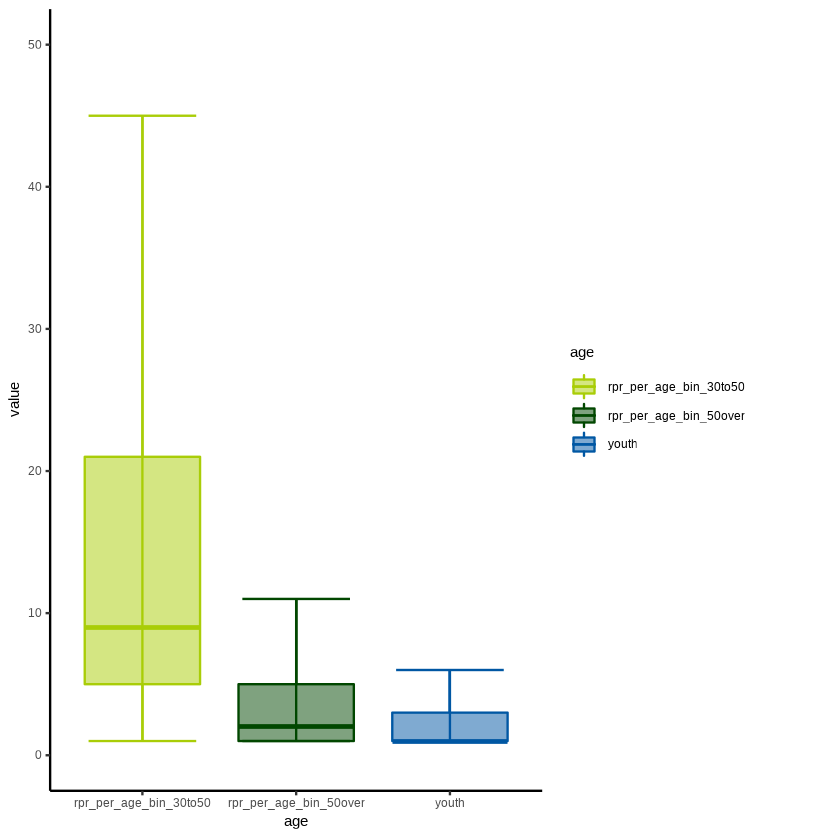

In [15]:
## 연령대별로 사업체 수 Box-plot

df_anova %>% 
    ggplot(aes(x = age,
               y = value,
               fill = age,
               color = age))+
    stat_boxplot(geom = "errorbar",width=0.7)+
    geom_boxplot(alpha=0.5,outlier.shape = NA)+
    theme_classic()+
    coord_cartesian(ylim = c(0,50))+
    scale_fill_manual(values =c("#a9cd07","#014700" ,"#0057a3" ))+
    scale_color_manual(values =c("#a9cd07","#014700" ,"#0057a3" ))

#### 2. 연령대별 사업체 수에 용인시 내 격자별 비교

In [16]:
## 시각화를 위한 맵핑(Mapping)

data_16@data$id <- rownames(data_16@data)
map_16 <- fortify(data_16,region = "id")
map_merged_16<-left_join(map_16,data_16@data, by = "id")

- 청년 사업체

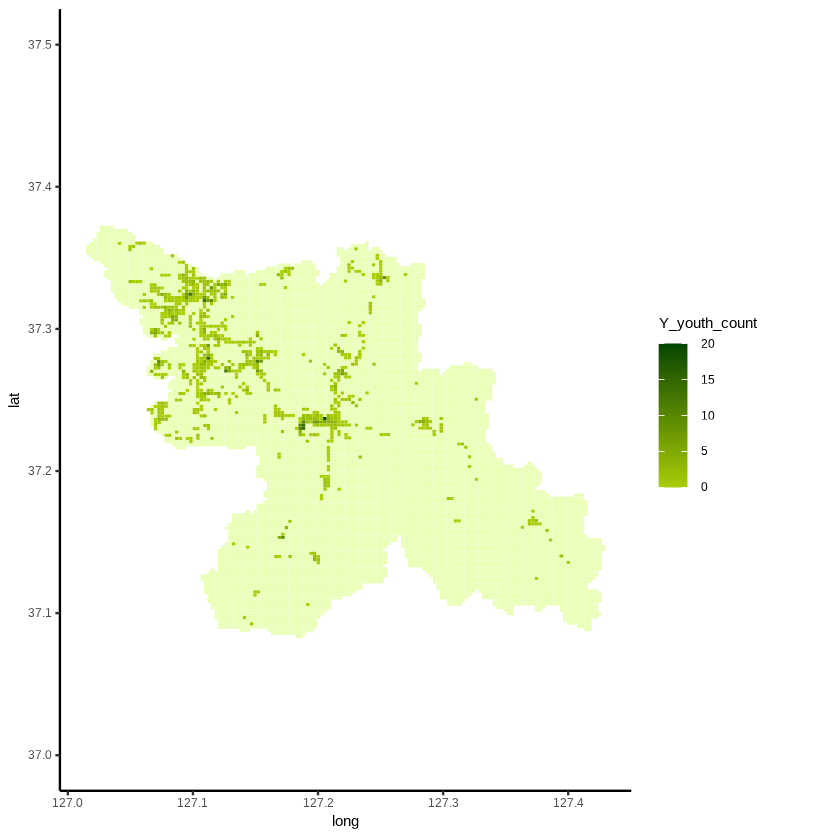

In [17]:
map_merged_16 %>% mutate(Y_youth_count = rpr_per_age_bin_10+rpr_per_age_bin_20 ) %>%  
    ggplot(aes(x = long,
               y = lat,
               group = group,
               fill = Y_youth_count))+ 
    geom_polygon()+
    coord_cartesian(ylim = c(37,37.5))+ 
    theme_classic()+
    scale_fill_continuous(low="#a9cd07", high="#014700", 
                          guide="colorbar",na.value="#EAFFB6")

- 30-50대

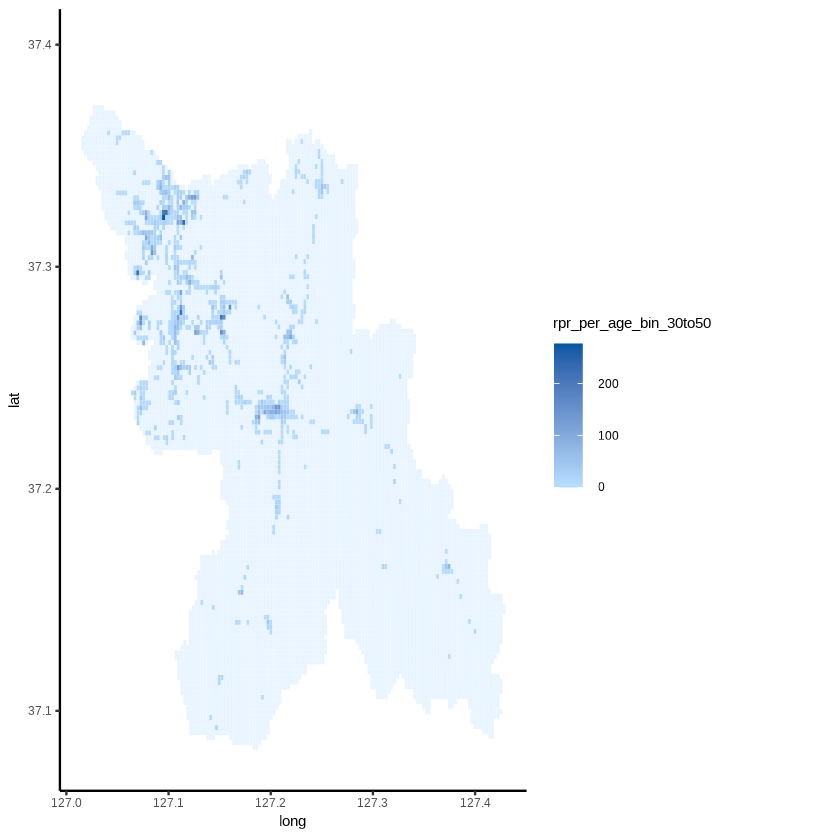

In [18]:
map_merged_16 %>% mutate(Y_youth_count = rpr_per_age_bin_10+rpr_per_age_bin_20 ) %>%  
    ggplot(aes(x = long,
               y = lat,
               group = group,
               fill = rpr_per_age_bin_30to50))+ 
    geom_polygon()+
    coord_cartesian(ylim = c(37.08,37.4))+ 
    theme_classic()+
    scale_fill_continuous(low="#B8DEff", high="#0057a3", 
                          guide="colorbar",na.value="#E8F4FF")

- 50대+

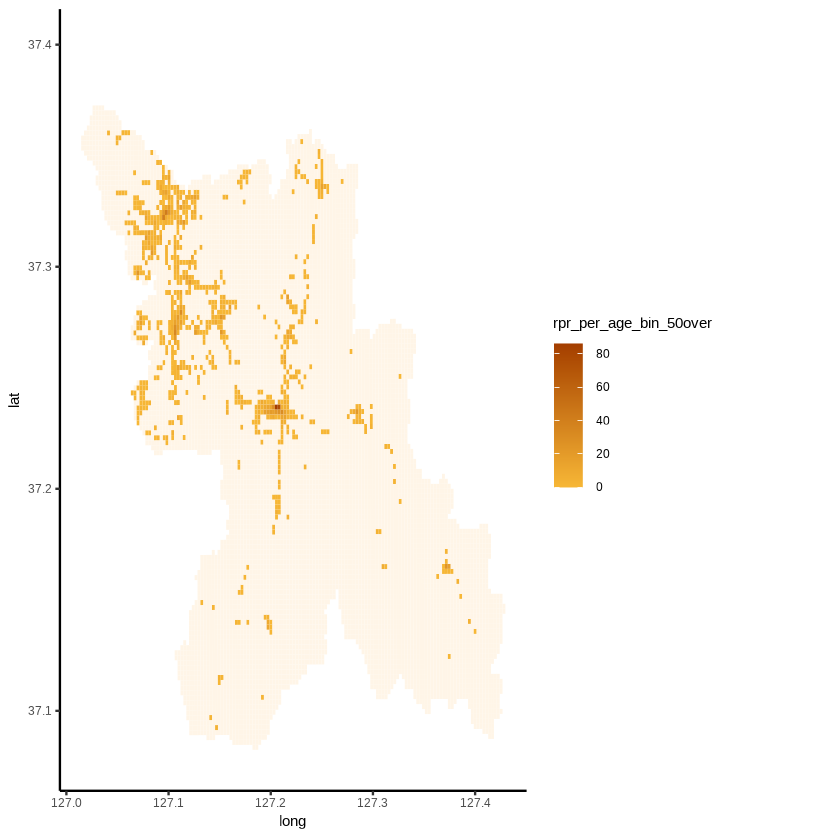

In [19]:
map_merged_16 %>% mutate(Y_youth_count = rpr_per_age_bin_10+rpr_per_age_bin_20 ) %>%  
    ggplot(aes(x = long,
               y = lat,
               group = group,
               fill = rpr_per_age_bin_50over, col = NULL))+ 
    geom_polygon()+
    coord_cartesian(ylim = c(37.08,37.4))+ 
    theme_classic()+
    scale_fill_continuous(low="#f7b736", high="#A43E00", 
                          guide="colorbar",na.value="#FFF5E7")

### 변수 만들기 1
- indcd_ 변수에서 "" 처리 되어있는 것 NA로 바꾼 후, gid_variety 계산

In [20]:
NA_create <- function(X) ifelse(X == "", NA, X)

gid_variety <- data %>% select(starts_with("indcd"))
gid_variety <- apply(gid_variety, 2, NA_create) 
gid_variety <- rowSums(!is.na(gid_variety))

### 변수 만들기 2
- Y_youth_count, Y_stable, smbiz_ratio, found_mid, age_2030, age_4050, age_6070, loan_excess, sales_rate
- 자세한 산출식은 보고서 참고

In [21]:
data = data %>% mutate(Y_youth_count = rpr_per_age_bin_10+rpr_per_age_bin_20,
                Y_stable = sales_est_amt_202009,       
                smbiz_ratio = smbiz_yn_cnt/ws_cnt,
                found_mid = (found_age_4+found_age_5+found_age_6)/ws_cnt,
                age_2030 = (age20_ratio+age30_ratio),
                age_4050 = (age40_ratio+age50_ratio),
                age_6070 = (age60_ratio+age70_ratio),
                loan_excess = (sme_loan_y_3+sme_loan_y_4+sme_loan_y_5+sme_loan_y_6)/sme_loan_cnt,
                sales_rate=(sales_est_amt_202009-sales_est_amt_201909)/sales_est_amt_201909,
               ) %>% 
select(c(gid, Y_youth_count, Y_stable, smbiz_ratio, 
         found_mid, age_2030, age_4050, age_6070, 
         loan_excess, sales_rate))
data$gid_variety = gid_variety

#### NA값은 0으로, Infinite 값은 1로 바꿔 주기

In [22]:
data  <- replace(data, is.na(data), 0)
data$sales_rate = ifelse(data$sales_rate == Inf, 1, data$sales_rate)

In [23]:
data <- data %>% left_join(road, by = "gid") %>% left_join(pop_flow, by = "gid")
data <- replace(data, is.na(data), 0)

In [24]:
write.csv(data, file = "data_v1.csv", row.names = F, fileEncoding = "UTF-8")

## 4. 클러스터링 변수 생성

In [25]:
pop_flow <- fread("pop_flow.csv",
                 header = T,
                 stringsAsFactors = F,
                 data.table = F,
                 encoding = "UTF-8",
                 drop = c("flpop_rate"))

cluster_data <- fread("cluster_data.csv",
                     header = T,
                     stringsAsFactors = F,
                     data.table = F,
                     encoding = "UTF-8")


cluster_data <- fread("cluster_data.csv",
                     header = T,
                     stringsAsFactors = F,
                     data.table = F,
                     encoding = "UTF-8")


data <- fread("17.용인시_소상공인_매출정보.csv",
             header = T,
             stringsAsFactors = F,
             data.table = F,
             encoding = "UTF-8",
             select = c("gid", "ws_cnt"))

### 1. 클러스터링용 데이터 결합

In [26]:
clust_data <- data %>% left_join(cluster_data, by = "gid") %>% left_join(pop_flow, by = "gid") %>% select(-gid)
clust_data <- replace(clust_data, is.na(clust_data), 0)

### 2. 클러스터링 사용변수 
- TMST_mean, house_counts, population, ws_cnt 사용
- Min-Max scaling 적용

In [27]:
clust_data1 <- clust_data %>% select(c(TMST_mean, house_counts, population, ws_cnt))
clust_scaled = clust_data1  %>% mutate(house_counts = (house_counts - min(house_counts))/(max(house_counts) - min(house_counts)) ,
                                        population = (population - min(population))/(max(population) - min(population)),
                                        TMST_mean = (TMST_mean - min(TMST_mean))/(max(TMST_mean) - min(TMST_mean)),
                                        ws_cnt = (ws_cnt - min(ws_cnt))/(max(ws_cnt) - min(ws_cnt)),
                                        )

### 3. K-means 알고리즘 적용

In [28]:
set.seed(2021)
kmeans1 <- kmeans(clust_scaled, nstart = 10, iter.max = 100, centers = 4)
clust_data1$cluster = kmeans1$cluster

#### 3.1 클러스터링 결과 시각화 - Box-plot

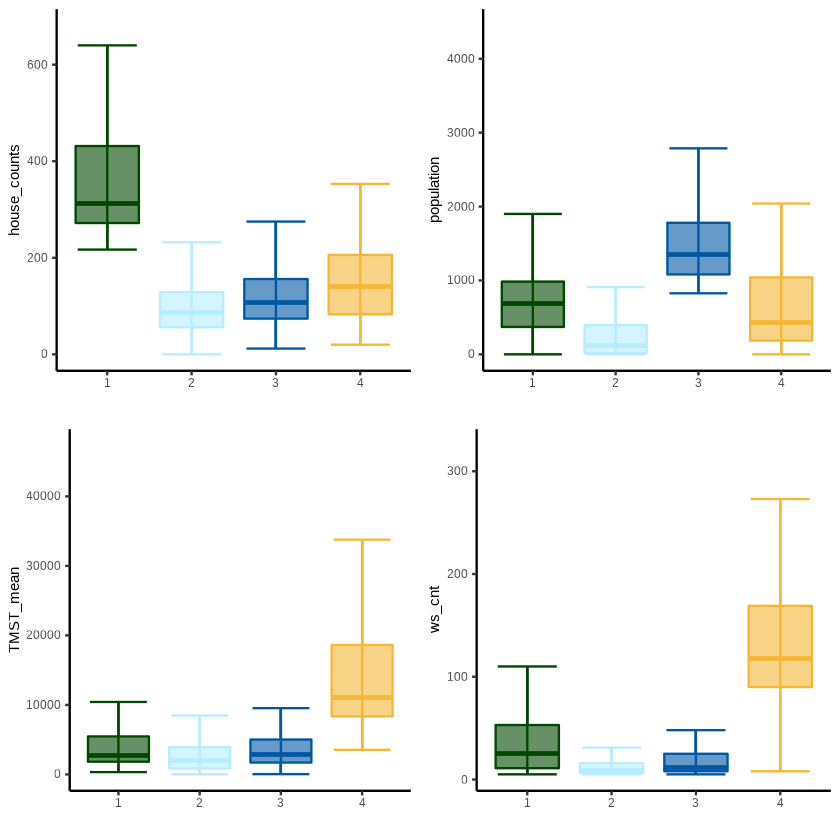

In [29]:
p1 <- clust_data1 %>% 
    ggplot(aes(x = as.factor(cluster), y = house_counts, color = as.factor(cluster), fill = as.factor(cluster))) +
    geom_boxplot(outlier.shape = NA,alpha = 0.6) + 
    theme_classic() + 
    theme(legend.position = "none") + 
    stat_boxplot(geom = "errorbar",width=0.7) + 
    xlab('')+
    scale_fill_manual(values = c("#014700","#b8ecff", "#0057a3", "#f7b736")) +
    scale_color_manual(values = c("#014700","#b8ecff", "#0057a3", "#f7b736"))


p2 <- clust_data1 %>% 
    ggplot(aes(x = as.factor(cluster), y = population, color = as.factor(cluster), fill = as.factor(cluster))) +
    geom_boxplot(outlier.shape = NA,alpha = 0.6) + 
    theme_classic() + 
    theme(legend.position = "none") + 
    stat_boxplot(geom = "errorbar",width=0.7) + 
    xlab('')+
    scale_fill_manual(values = c("#014700","#b8ecff", "#0057a3", "#f7b736")) +
    scale_color_manual(values = c("#014700","#b8ecff", "#0057a3", "#f7b736"))

p3 <- clust_data1 %>% 
    ggplot(aes(x = as.factor(cluster), y = TMST_mean, color = as.factor(cluster), fill = as.factor(cluster))) +
    geom_boxplot(outlier.shape = NA,alpha = 0.6) + 
    theme_classic() + 
    theme(legend.position = "none") + 
    stat_boxplot(geom = "errorbar",width=0.7) + 
    xlab('')+
    scale_fill_manual(values = c("#014700","#b8ecff", "#0057a3", "#f7b736")) +
    scale_color_manual(values = c("#014700","#b8ecff", "#0057a3", "#f7b736"))

p4 <- clust_data1 %>% 
    ggplot(aes(x = as.factor(cluster), y = ws_cnt, color = as.factor(cluster), fill = as.factor(cluster))) +
    geom_boxplot(outlier.shape = NA,alpha = 0.6) + 
    theme_classic() + 
    theme(legend.position = "none") + 
    stat_boxplot(geom = "errorbar",width=0.7) + 
    xlab('')+
    scale_fill_manual(values = c("#014700","#b8ecff", "#0057a3", "#f7b736")) +
    scale_color_manual(values = c("#014700","#b8ecff", "#0057a3", "#f7b736"))

gridExtra::grid.arrange(p1, p2, p3, p4, ncol = 2)

#### 3.2 클러스터링 결과 시각화 - 지도 시각화

In [30]:
clust_data1 <- cbind(clust_data1, data$gid)
clust_data <- data_16[which(data_16$gid %in% clust_data1[,6]),]
clust_data@data$ws_cnt <- as.factor(clust_data1[,5])
clust_data_1 <- clust_data[which(clust_data$ws_cnt == '1'), ]
clust_data_2 <- clust_data[which(clust_data$ws_cnt == '2'), ]
clust_data_3 <- clust_data[which(clust_data$ws_cnt == '3'), ]
clust_data_4 <- clust_data[which(clust_data$ws_cnt == '4'), ]

leaflet() %>%
  setView(lng = 127.220655 , lat = 37.22642, zoom = 10.5) %>% 
  addProviderTiles('CartoDB.Positron')  %>% 
  addPolygons(data = clust_data_1, #중심
            color = "#014700",
            fillOpacity = 0.2,
            weight = 1) %>%
  addPolygons(data = clust_data_2, #도로
            color = "#b8ecff", 
            fillOpacity = 0.7,
            weight = 1) %>%
  addPolygons(data = clust_data_3, #아파트
            color = "#0057a3", 
            fillOpacity = 0.5,
            weight = 1) %>%
  addPolygons(data = clust_data_4, #상권
            color = "#f7b736",
            fillOpacity = 0.8,
            weight = 1)  %>%
  addPolygons(data = data_16,
            color = "#a9cd07",
            fillOpacity = 0,
            weight = 0.1)

HTML widgets cannot be represented in plain text (need html)

In [31]:
clust_data1$gid = data$gid
clust_data2 <- clust_data1 %>% select(gid, cluster)
clust_data2$cluster <- ifelse(clust_data2$cluster == 1, "용인시중심생활권",
                             ifelse(clust_data2$cluster == 2, "주변지역상권", 
                                   ifelse(clust_data2$cluster == 3, "아파트주거단지", "중심상권")))
write.csv(clust_data2, "clustering.csv", row.names = F, fileEncoding = "UTF-8")

## 5. 최종 데이터셋 결합

- 앞에서 전처리 완료된 17번과 클러스터링 변수 결합

In [32]:
data <- fread("data_v1.csv",
             header = T,
             stringsAsFactors = F,
             data.table = F,
             encoding = "UTF-8")

cluster <- fread("clustering.csv",
                header = T,
                stringsAsFactors = F,
                data.table = F,
                encoding = "UTF-8")

In [33]:
data_model <- data  %>% left_join(cluster, by = "gid") %>% mutate_at(vars(cluster), as.factor)

In [34]:
write.csv(data_model, "data_f.csv", row.names = F, fileEncoding = "UTF-8")